# Developing your own AlphaZero

refering to https://www.youtube.com/watch?v=wuSQpLinRB4

## Managing Imports

In [1]:
import numpy as np
import math

import time

import matplotlib.pyplot as plt
import random
from tqdm.notebook import trange


import tensorflow as tf # only to check if gpu is used 

from keras.losses import categorical_crossentropy, mean_squared_error
from keras.models import Sequential, Model
from keras.activations import relu
from keras.layers import Dense, Conv2D, BatchNormalization, Flatten, Input, Layer, ReLU
from keras.optimizers import Adam
from keras import backend as K

In [2]:
print(tf.config.get_visible_devices())
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass
print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
# check if tensorflow is running on gpu
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")



Default GPU Device: /device:GPU:0


## Creating TicTacToe game

In [4]:
class TicTacToe: 
    def __init__(self): 
        self.row_count = 3
        self.column_count = 3
        self.action_size = self.row_count * self.column_count
    
    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        row = action // self.column_count 
        column = action % self.column_count
        state[row, column] = player
        return state
    
    def get_valid_moves(self, state): 
        return (state.reshape(-1) == 0).astype(np.uint8)

    def check_win(self, state, action): 
        if action == None: 
            return False
        row = action // self.column_count
        column = action % self.column_count
        player = state[row, column]
        return (
            np.sum(state[row, :]) == player * self.column_count
            or np.sum(state[:, column]) == player * self.row_count 
            or np.sum(np.diag(state)) == player * self.row_count
            or np.sum(np.diag(np.flip(state, axis=0))) == player * self.row_count
        )
        
    def get_value_and_terminated(self, state, action): 
        if self.check_win(state, action): 
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0: 
            return 0, True
        return 0, False

    def get_opponent(self, player): 
        return -player

    def get_opponent_value(self, value): 
        return -value

    def change_perspective(self, state, player): 
        return state * player

    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)
        
        return encoded_state

## Monte Carbo tree search (MCTS) 

In [5]:
class Node: 
    def __init__(self, game, args, state, parent=None, action_taken=None): 
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken

        self.children = []
        self.expandable_moves = game.get_valid_moves(state)

        self.visit_count = 0
        self.value_sum = 0

    def is_fully_expanded(self):
         return np.sum(self.expandable_moves) == 0 and len(self.children) > 0

    def select(self): 
        best_child = None
        best_ucb = -np.inf

        for child in self.children: 
            ucb = self.get_ucb(child)
            if ucb > best_ucb: 
                best_child = child
                best_ucb = ucb
        return best_child
    
    def get_ucb(self, child): 
        q_value =  1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args["C"] * math.sqrt(math.log(self.visit_count) / child.visit_count)

    def expand(self):
        action = np.random.choice(np.where(self.expandable_moves == 1)[0]) 
        self.expandable_moves[action] = 0

        child_state = self.state.copy()
        child_state = self.game.get_next_state(child_state, action, 1)
        child_state = self.game.change_perspective(child_state, player=-1)

        child = Node(self.game, self.args, child_state, self, action)
        self.children.append(child)
        return child

    def simulate(self): 
        value, is_terminal = self.game.get_value_and_terminated(self.state, self.action_taken)
        value = self.game.get_opponent_value(value)

        if is_terminal: 
            return value
        
        rollout_state = self.state.copy()
        rollout_player = 1
        while True: 
            valid_moves = self.game.get_valid_moves(rollout_state)
            action = np.random.choice(np.where(valid_moves == 1)[0])
            rollout_state = self.game.get_next_state(rollout_state, action, rollout_player)
            value, is_terminal = tictactoe.get_value_and_terminated(rollout_state, rollout_player)

            if is_terminal: 
                if rollout_player == -1:
                    value = self.game.get_opponent_value(value)
                return value
            
            rollout_player = self.game.get_opponent(rollout_player)

    def backpropagate(self, value): 
        self.value_sum += value
        self.visit_count += 1

        value = self.game.get_opponent_value(value)
        if self.parent is not None: 
            self.parent.backpropagate(value)

class MCTS:
    def __init__(self, game, args): 
        self.game = game
        self.args = args
    def search(self, state):
        # define root node 
        root = Node(self.game, self.args, state)
        
        for search in range(self.args["num_searches"]):
            node = root
            # selection phase

            while node.is_fully_expanded(): 
                node = node.select()
        
            value, is_terminal = tictactoe.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)

            if not is_terminal: 
                # expansion phase
                node = node.expand()
                # simulation phase
                value = node.simulate()
            
            # backpropagation phase
            node.backpropagate(value)
        
        # return visit_counts
        action_probs = np.zeros(self.game.action_size)
        for child in root.children: 
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs

## Alpha Monte Carbe tree search

In [6]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior
        
        self.children = []
        
        self.visit_count = 0
        self.value_sum = 0
        
    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
        return best_child
    
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior
    
    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)

                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)
                
        # return child
            
    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)  


class AlphaMCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model
        
    def search(self, state):
        root = Node(self.game, self.args, state)
        for search in range(self.args['num_searches']):
            timer = time.perf_counter()
            node = root
            
            while node.is_fully_expanded():
                node = node.select()
            
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)
            
            if not is_terminal:
                policy, value = self.model(
                    K.expand_dims(self.game.get_encoded_state(node.state), axis=0), training=False
                )
                policy = np.array(K.eval(K.squeeze(K.softmax(policy, axis=1), axis=0)))
                
                valid_moves = self.game.get_valid_moves(node.state)
                policy *= valid_moves
                policy /= np.sum(policy)
                
                value = value[0]
                
                node.expand(policy)
            
            node.backpropagate(value)
            print(time.perf_counter() - timer)
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        summe = np.sum(action_probs)
        action_probs /= summe
       
        return action_probs

## Create Neural Network

In [7]:
class ResNet(Model):
    def __init__(self, game, num_resBlocks, num_hidden):
        super(ResNet, self).__init__()
        
        self.startBlock = Sequential([
            Conv2D(num_hidden, kernel_size=3, padding='same', input_shape=(game.row_count, game.column_count, 3)),
            BatchNormalization(),
            ReLU()
        ])
        
        self.backBone = Sequential()
        for _ in range(num_resBlocks):
            self.backBone.add(ResBlock(num_hidden))
        
        self.policyHead = Sequential([
            Conv2D(32, kernel_size=3, padding='same'),
            BatchNormalization(),
            ReLU(),
            Flatten(),
            Dense(game.action_size)
        ])
        
        self.valueHead = Sequential([
            Conv2D(3, kernel_size=3, padding='same'),
            BatchNormalization(),
            ReLU(),
            Flatten(),
            Dense(1, activation='tanh')
        ])
        
    def call(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone.layers:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value
    

class ResBlock(Layer):
    def __init__(self, num_hidden):
        super(ResBlock, self).__init__()
        self.conv1 = Conv2D(num_hidden, kernel_size=3, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(num_hidden, kernel_size=3, padding='same')
        self.bn2 = BatchNormalization()
        
    def call(self, x):
        residual = x
        x = relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = relu(x)
        return x

## Creating Alpha Zero

In [8]:
class AlphaZero():
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer 
        self.game = game
        self.args = args
        self.mcts = AlphaMCTS(game, args, model)

    def self_play(self): 
        memory = []
        player = 1 
        state = self.game.get_initial_state()

        while True: 
            neutral_state = self.game.change_perspective(state, player)
            action_probs = self.mcts.search(neutral_state)
            memory.append((neutral_state, action_probs, player))

            action = np.random.choice(self.game.action_size, p=action_probs)
            
            state = self.game.get_next_state(state, action, player)

            value, is_terminal = self.game.get_value_and_terminated(state, action)

            if is_terminal: 
                return_memory = []
                for hist_neutral_state, hist_action_probs, hist_player in memory: 
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    return_memory.append((
                        self.game.get_encoded_state(hist_neutral_state), 
                        hist_action_probs, 
                        hist_outcome
                    ))
                return return_memory
            player = self.game.get_opponent(player)
            

            
    def train(self, memory): 
        random.shuffle(memory)
        for batch_index in range(0, len(memory), self.args["batch_size"]): 
            sample = memory[batch_index:min(len(memory)-1), batch_index+self.args["batch_size"]]
            state, policy_targets, value_targets = zip(*sample)
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1,1)

            state = K.cast(K.expand_dims(state, axis=0), "float32")
            policy_targets = K.cast(K.expand_dims(policy_targets, axis=0), "float32")
            value_targets = K.cast(K.expand_dims(value_targets, axis=0), "float32")

            out_policy, out_value = self.model(state)
            policy_loss = categorical_crossentropy(out_policy, policy_targets)
            value_loss = mean_squared_error(out_value, value_targets)
            loss = policy_loss + value_loss

            with tf.GradientTape() as tape:
                grads = tape.gradient(loss, self.model.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

            
    def learn(self): 
        for iteration in trange(self.args["num_iterations"]): 
            memory = []
            for self_play_iteration in trange(self.args["num_self_play_iterations"]):
                memory += self.self_play()
            for epoch in trange(self.args["num_epochs"]):
                self.train(memory)
            self.model.save('alpha_zero_I{iteration}.keras')

## Test game

In [ ]:
tictactoe = TicTacToe()

model = ResNet(tictactoe, 4, 64)
optimizer = Adam(learning_rate=0.001)
args = {
    "C": 2,
    "num_searches": 60,
    "num_iterations": 3,
    "num_self_play_iterations": 500,
    "num_epochs": 4, 
    "batch_size": 1024
}

alphaZero = AlphaZero(model, optimizer, tictactoe, args)
alphaZero.learn()


tf.Tensor([0.13233115], shape=(1,), dtype=float32) [0.09399989 0.13913971 0.11929208 0.11705099 0.13368994 0.10795849
 0.10509955 0.09518777 0.08858159]


<BarContainer object of 9 artists>

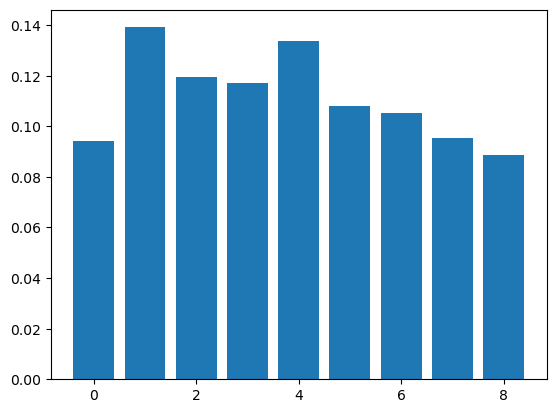

In [291]:
tictactoe = TicTacToe()

state = tictactoe.get_initial_state()
state = tictactoe.get_next_state(state, 2, 1)
state = tictactoe.get_next_state(state, 7, -1)

encoded_state = tictactoe.get_encoded_state(state)

tensor_state = K.expand_dims(encoded_state, axis=0) # add one layer

model = ResNet(tictactoe, 4, 64)
policy, value = model(tensor_state)
value = value[0]

policy = K.softmax(policy, axis=1)
policy = K.squeeze(policy, axis=0)
policy = K.eval(policy)
policy = np.array(policy)
print(value, policy)

plt.bar(range(tictactoe.action_size), policy)

In [9]:
tictactoe = TicTacToe()
player = 1

args= {
    "C": 2, 
    "num_searches": 1000
}

model = ResNet(tictactoe, 4, 64)

mcts = AlphaMCTS(tictactoe, args, model)

state = tictactoe.get_initial_state()

while True: 
    print(state)

    if player == 1: 
        valid_moves = tictactoe.get_valid_moves(state)
        print("valid_moves", [i for i in range(tictactoe.action_size) if valid_moves[i] == 1])
        action = int(input(f"{player}: "))

        if valid_moves[action] == 0: 
            print("action not valid")
            continue

    else: 
        neutral_state = tictactoe.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs) # child who has been visited the most

    state = tictactoe.get_next_state(state, action, player)

    value, is_terminal = tictactoe.get_value_and_terminated(state, action)

    if is_terminal:
        print(state)
        if value == 1: 
            print(player, "won")
        else: 
            print("draw")
        break
    player = tictactoe.get_opponent(player)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6, 7, 8]
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
0.17688310000000484
0.01632539999999949
0.020972100000001603
0.019084900000002847
0.02107390000000464
0.005057100000001924
0.017443299999996498
0.01613670000000411
0.0175609999999935
0.017272800000000643
0.01820990000000222
0.020168000000005293
0.01748150000000237
0.018017000000000394
0.017864699999996958
0.019317999999998392
0.01923320000000217
0.020535000000002412
0.019628399999994883
0.020315699999997605
0.020488699999994253
0.02039010000000019
0.021493599999999446
0.021288599999998326
0.022075799999996093
0.02260880000000043
0.023369399999999985
0.02607580000000098
0.023426299999997013
0.021293199999995238
0.021305400000002805
0.006904800000000932
0.006583599999999024
0.022156599999995308
0.00797510000000301
0.020810699999998405
0.0069415000000034865
0.007762100000000771
0.02123380000000452
0.022189400000002024
0.023070000000004143
0.02248039999999918
0.0226353999999986

ValueError: invalid literal for int() with base 10: ''